In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from pathlib import Path
import pandas as pd
import cv2
import os
import numpy as np
from os import sep
import shutil
import json
import yaml
import matplotlib.pyplot as plt
import random
import time
from tqdm.notebook import tqdm_notebook
import concurrent.futures
import multiprocessing as mp

In [2]:
#Data sources
DATA_FLDR_NM = 'Data'
IN_DATASET_NM = 'xview-dataset'
IMAGE_FLDR_NM = 'train_images'
IN_LABELS_FLDR_NM = 'train_labels'
LABELS_XML_NM = 'xView_train.geojson'

#Output folders and file names
OUT_DATASET_NM = 'xview-yolo-dataset'
CLASS_MAP_JSON_NM = 'xView_class_map.json'
OUT_COCO_JSON_NM = 'COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
OUT_CFG_FLDR_NM = 'YOLO_cfg'
OUT_DATAFRAME_NM = 'xview_labels.parquet'
YAML_NM = 'xview_yolo.yaml'
CHUNK_WIDTH = 640  # width of the images being created
CHUNK_HEIGHT = 640
MIN_CHUNK_HEIGHT = 320 # no images will be kept if the image chunk is smaller than this
MIN_CHUNK_WIDTH = 320
IMAGE_WRITING = True #True to re-perform image cropping, False just to regenerated other data
TEST_FRACTION = 0.1
JPEG_COMPRESSION = 95 # For the saved files
VAL_FRACTION = 0.1
RANDOM_SEED = 2023
DEBUG = False

in_kaggle = os.environ.get('PWD') == '/kaggle/working'
if in_kaggle:
    in_dataset_pth = Path('/kaggle/input/xview-dataset')
    out_dataset_pth = Path('/kaggle/working/')
    future_ds_img_fldr = Path(f'/kaggle/input/{OUT_DATASET_NM}/{OUT_IMAGE_FLDR_NM}')
    future_ds_cfg_fldr = Path(f'/kaggle/input/{OUT_DATASET_NM}/{OUT_CFG_FLDR_NM}')

labels_json_pth = in_dataset_pth / IN_LABELS_FLDR_NM / LABELS_XML_NM
img_fldr_pth = in_dataset_pth / IMAGE_FLDR_NM / IMAGE_FLDR_NM
save_images_fldr_pth = out_dataset_pth / OUT_IMAGE_FLDR_NM 
out_data_parquet_pth = out_dataset_pth / OUT_DATAFRAME_NM
out_json_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM 
class_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM
cfg_fldr_pth = out_dataset_pth / OUT_CFG_FLDR_NM
coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM
yolo_yaml_pth = cfg_fldr_pth / YAML_NM
train_txt_pth = cfg_fldr_pth / 'train.txt'
val_txt_pth = cfg_fldr_pth / 'train.txt'
test_txt_pth = cfg_fldr_pth / 'test.txt'

def make_empty_dir(directory):
    if directory.is_dir():
        shutil.rmtree(directory)
    os.makedirs(directory)

make_empty_dir(cfg_fldr_pth)
if IMAGE_WRITING:
    make_empty_dir(save_images_fldr_pth)

random.seed(RANDOM_SEED)

print(f'The input images are found at {cfg_fldr_pth}')
print(f'The input labels are found at  {labels_json_pth}')
print(f'Configuration files will be saved to {cfg_fldr_pth}')
print(f'YOLO image files will be saved to {save_images_fldr_pth}')

The input images are found at /kaggle/working/YOLO_cfg
The input labels are found at  /kaggle/input/xview-dataset/train_labels/xView_train.geojson
Configuration files will be saved to /kaggle/working/YOLO_cfg
YOLO image files will be saved to /kaggle/working/images


In [3]:
def get_boxes(in_df, class_lst=[]):
    if class_lst:
        in_df = in_df[in_df['TYPE_ID'].isin(class_lst)]
    unique_images = in_df.IMAGE_ID.unique().tolist()
    boxs = {}

    for image in tqdm_notebook(unique_images):
        mask = in_df['IMAGE_ID'] == image
        masked = in_df[mask][['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX']]
        boxs[image] = masked.values.tolist()
    return boxs


def print_first_n_lines(file_path, n):
    try:
        with open(file_path, 'r') as file:
            for line_num, line in enumerate(file, 1):
                if line_num > n:
                    break
                print(line.strip())
    except FileNotFoundError:
        print('Unable to open file')


def load_image(file_pth): #for display
    image_obj = cv2.imread(file_pth)
    image_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2RGB)
    return image_obj


def load_bgr_image(file_pth): # for processing only, no need to visualise the image
    image_obj = cv2.imread(file_pth)
    return image_obj

def display_images(image_lst, boxes_dictionary, image_fldr, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = str(image_fldr / img_nm)
        img = load_image(image_path)

        # create a bounding box with the data & draw it
        if img_nm in boxes_dictionary:
            for box in boxes_dictionary[img_nm]:
                box_id, x_min, y_min, x_max, y_max = box
                x_min, y_min, x_max, y_max = int(x_min), int(y_max), int(x_max), int(y_min)
                # (left top), (right, bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[box_id]
                    else:
                        box_label = str(box_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()
    return

#Convert YOLO to CV2 rectangle (l,t),(r,b)
def get_corners(x_cen, y_cen, an_width, an_height, im_width, im_height):
    x_cen, y_cen, an_width, an_height = float(x_cen), float(y_cen), float(an_width), float(an_height)
    left = (x_cen - an_width/2)*im_width
    top = (y_cen - an_height/2)*im_height
    right = (x_cen + an_width/2)*im_width
    bottom = (y_cen + an_height/2)*im_height
    return int(left), int(top), int(right), int(bottom)

def display_yolo_images(image_lst, image_fldr, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    _, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = image_fldr / img_nm
        text_fn = image_path.stem + '.txt'
        boxes_path = image_fldr / text_fn
        img = load_image(str(image_path))
        im_h, im_w, _ = img.shape
        with open(boxes_path) as text_file:
            annotations = [line.rstrip().split() for line in text_file]

        # create a bounding box with the data & draw it
        for ann in annotations:
                class_id = ann[0]
                x_centre, y_centre, w, h = ann[1], ann[2], ann[3], ann[4]
                x_min, y_min, x_max, y_max = get_corners(x_centre, y_centre, w, h, im_w, im_h)
                # (left top), (right bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[int(class_id)]
                    else:
                        box_label = str(class_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()
    return

# For a given square within a chunk of a larger image, find any boxes in it
# Return the boxes in YOLO format relative to the chunk boundary
def match_boxes(box_list, chnk_lims):
    boxes_lists = []
    le, to = chnk_lims[0], chnk_lims[1]  # chunk_limits = [c, r, chunk_w, chunk_h]
    w, h  = chnk_lims[2], chnk_lims[3]
    for box in box_list:
        o_left, o_top, o_right, o_bottom = box[1], box[2], box[3], box[4]
        left, right = (o_left - le)/w, (o_right - le)/w  # translate and normalise
        top, bottom = (o_top - to)/h, (o_bottom - to)/h

        h_match = (0 <= left < 1) or (0 < right <= 1)
        v_match = (0 <= top < 1) or (0 < bottom <= 1)

        if v_match and h_match:
            clipped = np.clip([left, top, right, bottom], a_min=0, a_max=1)
            l, t, r, b = clipped[0], clipped[1], clipped[2], clipped[3]
            bounding_box = [str(box[0]),
                            str(round((l + r)/2, 5)),
                            str(round((t + b)/2, 5)),
                            str(round(r-l, 5)),
                            str(round(b-t, 5))]
            boxes_lists.append(bounding_box)
    return boxes_lists

In [4]:
with open(labels_json_pth, 'r') as infile:
    data = json.load(infile)
    keys = list(data.keys())

feature_list = data['features']
COLUMNS = ['IMAGE_ID', 'TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX', 'LONG', 'LAT']

data = []
for feature in tqdm_notebook(feature_list):
    properties = feature['properties'] # a dict
    img_id = properties['image_id']  # '389.tif'
    type_id = properties['type_id']
    bbox = properties['bounds_imcoords'].split(",")  # eg '1917,38,1958,64'
    geometry = feature ['geometry']
    coords = geometry['coordinates'][0] #for some reason it's a list of lists
    long = coords[0][0] / 2  + coords[2][0] / 2
    lat = coords[0][1] / 2  + coords[1][1] / 2
    one_row = [img_id, type_id, bbox[0], bbox[1], bbox[2], bbox[3], long, lat]
    data.append(one_row)

instances = len(data)
print(f'There are {instances} object instances in the original dataset')

  0%|          | 0/601937 [00:00<?, ?it/s]

There are 601937 object instances in the original dataset


In [5]:
df = pd.DataFrame(data, columns = COLUMNS)
df[['XMIN', 'YMIN', 'XMAX', 'YMAX']] = df[['XMIN', 'YMIN', 'XMAX', 'YMAX']].apply(pd.to_numeric)
df.head()

IMAGE_ID  TYPE_ID  XMIN  YMIN  XMAX  YMAX       LONG        LAT
0  2355.tif       73  2712  1145  2746  1177 -90.531640  14.566091
1  2355.tif       73  2720  2233  2760  2288 -90.531603  14.562313
2  2355.tif       73  2687  1338  2740  1399 -90.531694  14.565379
3  2355.tif       73  2691  1201  2730  1268 -90.531704  14.565838
4  2355.tif       73  2671   838  2714   869 -90.531766  14.567149

In [6]:
df = df[(df.TYPE_ID != 75) & (df.TYPE_ID != 82)]   # removing erroneous labels
print(f'{instances - len(df)} rows removed, leaving {len(df)} rows')

79 rows removed, leaving 601858 rows


In [7]:
df.head()

IMAGE_ID  TYPE_ID  XMIN  YMIN  XMAX  YMAX       LONG        LAT
0  2355.tif       73  2712  1145  2746  1177 -90.531640  14.566091
1  2355.tif       73  2720  2233  2760  2288 -90.531603  14.562313
2  2355.tif       73  2687  1338  2740  1399 -90.531694  14.565379
3  2355.tif       73  2691  1201  2730  1268 -90.531704  14.565838
4  2355.tif       73  2671   838  2714   869 -90.531766  14.567149

In [8]:
old_length = len(df)
df = df[df.IMAGE_ID != '1395.tif']
print(f'{old_length - len(df)} rows removed, leaving {len(df)}')
df.head()

131 rows removed, leaving 601727


IMAGE_ID  TYPE_ID  XMIN  YMIN  XMAX  YMAX       LONG        LAT
0  2355.tif       73  2712  1145  2746  1177 -90.531640  14.566091
1  2355.tif       73  2720  2233  2760  2288 -90.531603  14.562313
2  2355.tif       73  2687  1338  2740  1399 -90.531694  14.565379
3  2355.tif       73  2691  1201  2730  1268 -90.531704  14.565838
4  2355.tif       73  2671   838  2714   869 -90.531766  14.567149

In [9]:
old_dict = {
    11:'Fixed-wing Aircraft', 12:'Small Aircraft', 13:'Passenger/Cargo Plane', 15:'Helicopter',
    17:'Passenger Vehicle', 18:'Small Car', 19:'Bus', 20:'Pickup Truck', 21:'Utility Truck',
    23:'Truck', 24:'Cargo Truck', 25:'Truck Tractor w/ Box Trailer', 26:'Truck Tractor',27:'Trailer',
    28:'Truck Tractor w/ Flatbed Trailer', 29:'Truck Tractor w/ Liquid Tank', 32:'Crane Truck',
    33:'Railway Vehicle', 34:'Passenger Car', 35:'Cargo/Container Car', 36:'Flat Car', 37:'Tank car',
    38:'Locomotive', 40:'Maritime Vessel', 41:'Motorboat', 42:'Sailboat', 44:'Tugboat', 45:'Barge',
    47:'Fishing Vessel', 49:'Ferry', 50:'Yacht', 51:'Container Ship', 52:'Oil Tanker',
    53:'Engineering Vehicle', 54:'Tower crane', 55:'Container Crane', 56:'Reach Stacker',
    57:'Straddle Carrier', 59:'Mobile Crane', 60:'Dump Truck', 61:'Haul Truck', 62:'Scraper/Tractor',
    63:'Front loader/Bulldozer', 64:'Excavator', 65:'Cement Mixer', 66:'Ground Grader', 71:'Hut/Tent',
    72:'Shed', 73:'Building', 74:'Aircraft Hangar', 76:'Damaged Building', 77:'Facility', 79:'Construction Site',
    83:'Vehicle Lot', 84:'Helipad', 86:'Storage Tank', 89:'Shipping container lot', 91:'Shipping Container',
    93:'Pylon', 94:'Tower'}

In [10]:
old_keys = sorted(list(old_dict.keys()))
new_dict = {old_dict[x]:y for y, x in enumerate(old_keys)}
class_map_dict = {y:old_dict[x] for y, x in enumerate(old_keys)}
with open(out_json_map_pth, "w") as json_file:
    json.dump(class_map_dict, json_file)
print(class_map_dict)

{0: 'Fixed-wing Aircraft', 1: 'Small Aircraft', 2: 'Passenger/Cargo Plane', 3: 'Helicopter', 4: 'Passenger Vehicle', 5: 'Small Car', 6: 'Bus', 7: 'Pickup Truck', 8: 'Utility Truck', 9: 'Truck', 10: 'Cargo Truck', 11: 'Truck Tractor w/ Box Trailer', 12: 'Truck Tractor', 13: 'Trailer', 14: 'Truck Tractor w/ Flatbed Trailer', 15: 'Truck Tractor w/ Liquid Tank', 16: 'Crane Truck', 17: 'Railway Vehicle', 18: 'Passenger Car', 19: 'Cargo/Container Car', 20: 'Flat Car', 21: 'Tank car', 22: 'Locomotive', 23: 'Maritime Vessel', 24: 'Motorboat', 25: 'Sailboat', 26: 'Tugboat', 27: 'Barge', 28: 'Fishing Vessel', 29: 'Ferry', 30: 'Yacht', 31: 'Container Ship', 32: 'Oil Tanker', 33: 'Engineering Vehicle', 34: 'Tower crane', 35: 'Container Crane', 36: 'Reach Stacker', 37: 'Straddle Carrier', 38: 'Mobile Crane', 39: 'Dump Truck', 40: 'Haul Truck', 41: 'Scraper/Tractor', 42: 'Front loader/Bulldozer', 43: 'Excavator', 44: 'Cement Mixer', 45: 'Ground Grader', 46: 'Hut/Tent', 47: 'Shed', 48: 'Building', 49

In [11]:
df['TYPE_ID'] = df['TYPE_ID'].apply(lambda x: new_dict[old_dict[x]])
df.head(3)

IMAGE_ID  TYPE_ID  XMIN  YMIN  XMAX  YMAX       LONG        LAT
0  2355.tif       48  2712  1145  2746  1177 -90.531640  14.566091
1  2355.tif       48  2720  2233  2760  2288 -90.531603  14.562313
2  2355.tif       48  2687  1338  2740  1399 -90.531694  14.565379

  0%|          | 0/786 [00:00<?, ?it/s]

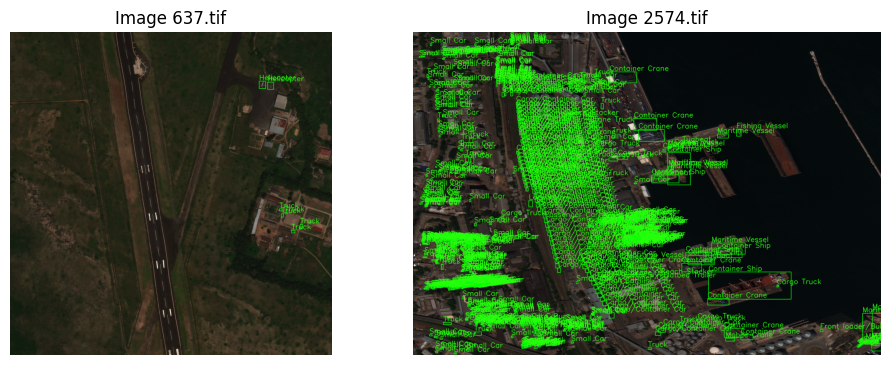

In [12]:
all_classes = list(class_map_dict.keys())
transport_only = [x for x in all_classes if x < 48]

boxes = get_boxes(df, transport_only)
images_for_display = random.choices(list(boxes.keys()), k=2)
display_images(images_for_display, boxes, img_fldr_pth, max_images=2, no_cols=2, text=True, class_map=class_map_dict) #adjust as desired

In [13]:
boxes_dict = get_boxes(df) # returns a dict of the form {filename:[['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX'],[..],[..],..]}

  0%|          | 0/846 [00:00<?, ?it/s]

In [14]:
def process_image(img_fn, 
                  dir_pth=img_fldr_pth, 
                  boxes=boxes_dict, 
                  out_dir=save_images_fldr_pth, 
                  c_height=CHUNK_HEIGHT, 
                  c_width=CHUNK_WIDTH,  
                  jpg_q=JPEG_COMPRESSION,
                  min_h=MIN_CHUNK_HEIGHT,
                  min_w=MIN_CHUNK_WIDTH,
                  writing=IMAGE_WRITING
                 ):
    
    labels_list = boxes[img_fn]
    img_pth = str(dir_pth / img_fn)
    im = load_bgr_image(img_pth)
    full_h, full_w, _ = im.shape
    y_boxes= {}
    f_names, widths, heights = [], [], []
    
    for r in range(0, full_h, c_height):
        for c in range(0, full_w, c_width):
            stem = img_fn.split('.')[0]
            fn = str(f"img_{stem}_{r}_{c}.jpg")
            out_pth = str(out_dir / fn)
            width = c_width
            height = c_height
            if r + height > full_h:
                height = full_h - r
            if c + width > full_w:
                width = full_w - c
            big_enough = (c_height > min_h) and (c_width > min_w)
            if big_enough:
                if writing:
                    cv2.imwrite(out_pth, im[r:r+height, c:c+height,:],  [int(cv2.IMWRITE_JPEG_QUALITY), jpg_q])
                    chunk_limits = [c, r, width, height]
                y_boxes[fn] = match_boxes(labels_list, chunk_limits)
                f_names.append(fn)
                widths.append(width)
                heights.append(height)
    return f_names, widths, heights, y_boxes

In [15]:
img_fns = df.IMAGE_ID.unique().tolist()
if DEBUG:
    img_fns = img_fns[:len(img_fns)//120]
    df = df[df['IMAGE_ID'].isin(img_fns)]

In [16]:
start_time = time.time()
num_threads = mp.cpu_count() 
overall_progress = tqdm_notebook(total=len(img_fns), desc="Creating and saving image tiles")
yolo_boxes= {}
file_names, widths, heights = [], [], []

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for f_names, c_widths, c_heights, y_boxes in executor.map(process_image, img_fns):
        file_names.extend(f_names)
        widths.extend(c_widths)
        heights.extend(c_heights)
        yolo_boxes.update(y_boxes)
        overall_progress.update(1)
overall_progress.close()

image_data = {file_names[i]: [widths[i], heights[i]] for i in range(len(file_names))}
time_taken=time.time() - start_time

Creating and saving image tiles:   0%|          | 0/846 [00:00<?, ?it/s]

# Write the new YOLO formatted text files

In [17]:
all_image_files = os.listdir(save_images_fldr_pth)
for image_fn in tqdm_notebook(all_image_files):
    stem = image_fn.split('.')[0]
    fn = str (stem) + '.txt'
    txt_pth = str(save_images_fldr_pth / fn)
    seperator = ' '
    with open(txt_pth, 'a') as f:
        if image_fn in yolo_boxes:
            for bbox in yolo_boxes[image_fn]:
                txt = seperator.join(bbox) + '\n'
                f.write(txt)

  0%|          | 0/24806 [00:00<?, ?it/s]

In [19]:
text_paths = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
column_names = ['Class_ID', 'x_center', 'y_center', 'width', 'height']
data = []
for file_path in text_paths:
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            row_data = {col: val for col, val in zip(column_names, values)}
            row_data['File_Name'] = file_path.name
            data.append(row_data)

out_df = pd.DataFrame(data)
out_df['Class_ID']=out_df['Class_ID'].astype(int)
out_df['Class_Name'] = out_df['Class_ID'].map(class_map_dict).fillna('unknown')
out_df = out_df[['File_Name', 'Class_Name', 'Class_ID', 'x_center', 'y_center', 'width', 'height']]
out_df.to_parquet(out_data_parquet_pth, index=False)
out_df.head()

File_Name   Class_Name  Class_ID x_center y_center    width  \
0  img_2565_1280_640.txt  Cargo Truck        10  0.14688  0.02422     0.05   
1  img_2565_1280_640.txt     Building        48  0.24297  0.02734  0.12969   
2  img_2565_1280_640.txt     Building        48  0.17344  0.06641  0.34688   
3  img_2565_1280_640.txt     Building        48  0.15625  0.97578   0.3125   
4  img_2565_1280_640.txt        Truck         9  0.41406  0.85625  0.02187   

    height  
0  0.01094  
1  0.05469  
2  0.11719  
3  0.04844  
4   0.0375

In [22]:
out_df.tail(10)

File_Name         Class_Name  Class_ID x_center y_center  \
662140  img_1088_640_2560.txt  Construction Site        52  0.92441  0.38594   
662141  img_1088_640_2560.txt  Construction Site        52  0.71417  0.52969   
662142  img_1120_1920_640.txt          Small Car         5  0.90625  0.02656   
662143  img_1120_1920_640.txt          Small Car         5  0.97188  0.02656   
662144  img_1120_1920_640.txt          Small Car         5  0.94609   0.0875   
662145  img_1120_1920_640.txt          Small Car         5  0.99531  0.17969   
662146  img_1120_1920_640.txt        Vehicle Lot        53  0.92031  0.02422   
662147  img_1120_1920_640.txt        Vehicle Lot        53  0.95938  0.04844   
662148  img_1120_1920_640.txt        Vehicle Lot        53  0.97031  0.11406   
662149  img_1120_1920_640.txt        Vehicle Lot        53  0.99062  0.17656   

          width   height  
662140  0.13228  0.19688  
662141   0.1748      0.2  
662142    0.025  0.02188  
662143  0.02187  0.01875  
662144  0.02344  0.02187  
662145  0.00938  0.02187  
662146  0.10313  0.04844  
662147  0.08125  0.06562  
662148  0.05937    0.075  
662149  0.01875  0.09375

# Display images to check whether the 

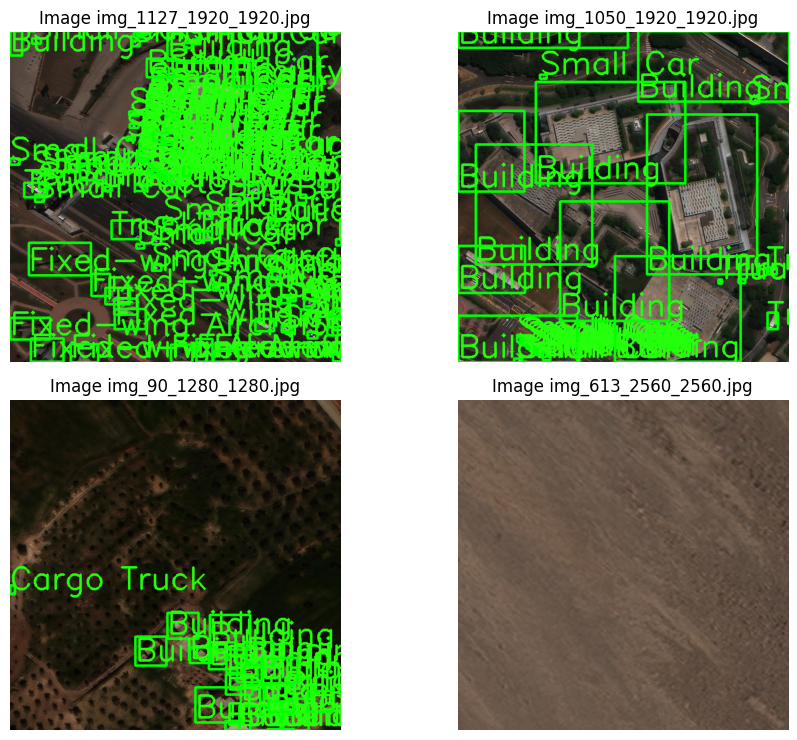

In [24]:
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=True,  class_map=class_map_dict)

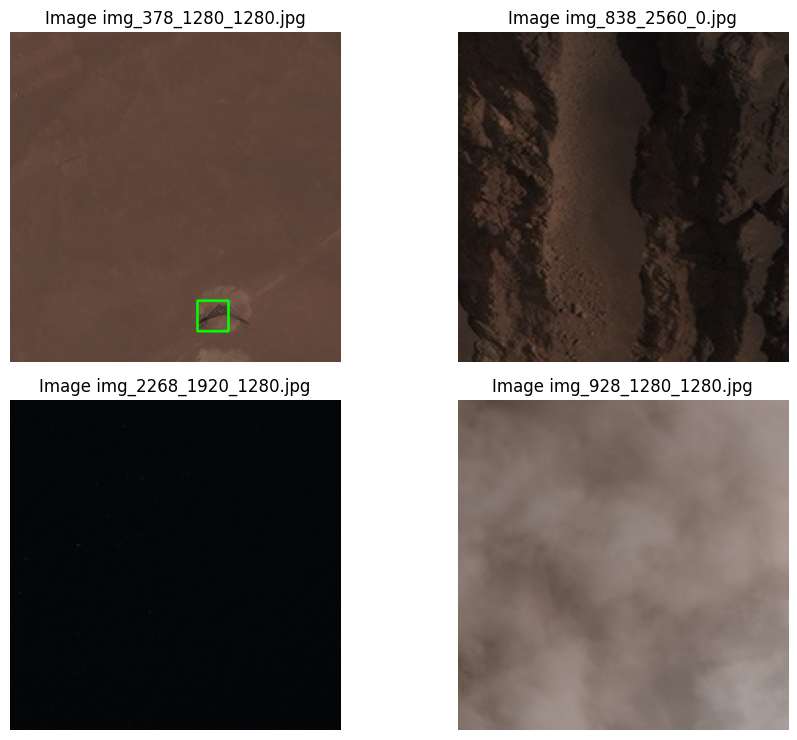

In [25]:
#without text labels
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=False)

# Split the data

In [26]:
total_images = len(filenames)
indices = list(range(total_images))
random.shuffle(indices)

train_fraction = 1 - TEST_FRACTION - VAL_FRACTION
train_sp = int(np.floor(train_fraction * len(indices))) # The training-validation split
valid_sp = int(np.floor(VAL_FRACTION * len(indices))) + train_sp # The validation-test split
train_idx, val_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(val_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)

 Training set size: 	 19844
 Validation set size: 	 2480
 Test set size: 	 2482
 Total dataset: 	 24806


In [27]:
files = ['train.txt', 'val.txt', 'test.txt']
splits = [train_idx, val_idx, test_idx]

for fn, split in zip(files, splits):
    txt_pth = cfg_fldr_pth / fn
    with open(txt_pth, 'a') as f:
        for ind in split:
            f.write(str(future_ds_img_fldr / filenames[ind]) + '\n')
        print(f'{fn[:-4]} file written to {txt_pth}, with {len(split) } samples')

train file written to /kaggle/working/YOLO_cfg/train.txt, with 19844 samples
val file written to /kaggle/working/YOLO_cfg/val.txt, with 2480 samples
test file written to /kaggle/working/YOLO_cfg/test.txt, with 2482 samples


# Make a yaml file

In [28]:
config = {'train': str(future_ds_cfg_fldr / files[0]),
          'val': str(future_ds_cfg_fldr / files[1]),
          'test': str(future_ds_cfg_fldr / files[2]),
          'nc': len(class_map_dict),
          'names': class_map_dict
          }

with open(yolo_yaml_pth, "w") as file:
    yaml.dump(config, file, default_style=None, default_flow_style=False, sort_keys=False)
print(f'yaml file written to {yolo_yaml_pth}')

yaml file written to /kaggle/working/YOLO_cfg/xview_yolo.yaml


# Just checking the first few lines of the train.txt/ val.txt / test.txt file and yaml file

In [29]:
for split in ['train', 'val', 'test']:
    print(f'{split} text file')
    print_first_n_lines(cfg_fldr_pth / f'{split}.txt', 2)

train text file
/kaggle/input/xview-yolo-dataset/images/img_907_0_640.jpg
/kaggle/input/xview-yolo-dataset/images/img_561_1280_640.jpg
val text file
/kaggle/input/xview-yolo-dataset/images/img_1789_640_1920.jpg
/kaggle/input/xview-yolo-dataset/images/img_2214_0_640.jpg
test text file
/kaggle/input/xview-yolo-dataset/images/img_1224_1280_1280.jpg
/kaggle/input/xview-yolo-dataset/images/img_1374_640_640.jpg


In [30]:
print_first_n_lines(yolo_yaml_pth, 10)

train: /kaggle/input/xview-yolo-dataset/YOLO_cfg/train.txt
val: /kaggle/input/xview-yolo-dataset/YOLO_cfg/val.txt
test: /kaggle/input/xview-yolo-dataset/YOLO_cfg/test.txt
nc: 60
names:
0: Fixed-wing Aircraft
1: Small Aircraft
2: Passenger/Cargo Plane
3: Helicopter
4: Passenger Vehicle


In [32]:
txt_fnames = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
text_list = random.choices(txt_fnames, k=2)
print(text_list)
for text_f in text_list:
    print(f'Reading {text_f}')
    print_first_n_lines(text_f, 3)  

[PosixPath('/kaggle/working/images/img_1749_2560_2560.txt'), PosixPath('/kaggle/working/images/img_41_2560_2560.txt')]
Reading /kaggle/working/images/img_1749_2560_2560.txt
48 0.01562 0.01797 0.03125 0.03594
48 0.74063 0.98438 0.05625 0.03125
5 0.29141 0.09219 0.02969 0.01562
Reading /kaggle/working/images/img_41_2560_2560.txt
50 0.60547 0.73269 0.07031 0.07308


In [33]:
print(text_list)


[PosixPath('/kaggle/working/images/img_1749_2560_2560.txt'), PosixPath('/kaggle/working/images/img_41_2560_2560.txt')]


In [34]:
out_data = pd.read_parquet(out_data_parquet_pth)
out_data.head()

File_Name   Class_Name  Class_ID x_center y_center    width  \
0  img_2565_1280_640.txt  Cargo Truck        10  0.14688  0.02422     0.05   
1  img_2565_1280_640.txt     Building        48  0.24297  0.02734  0.12969   
2  img_2565_1280_640.txt     Building        48  0.17344  0.06641  0.34688   
3  img_2565_1280_640.txt     Building        48  0.15625  0.97578   0.3125   
4  img_2565_1280_640.txt        Truck         9  0.41406  0.85625  0.02187   

    height  
0  0.01094  
1  0.05469  
2  0.11719  
3  0.04844  
4   0.0375

In [35]:
with open(out_json_map_pth, "r") as json_file:
    loaded_dict = json.load(json_file)
print(loaded_dict)

{'0': 'Fixed-wing Aircraft', '1': 'Small Aircraft', '2': 'Passenger/Cargo Plane', '3': 'Helicopter', '4': 'Passenger Vehicle', '5': 'Small Car', '6': 'Bus', '7': 'Pickup Truck', '8': 'Utility Truck', '9': 'Truck', '10': 'Cargo Truck', '11': 'Truck Tractor w/ Box Trailer', '12': 'Truck Tractor', '13': 'Trailer', '14': 'Truck Tractor w/ Flatbed Trailer', '15': 'Truck Tractor w/ Liquid Tank', '16': 'Crane Truck', '17': 'Railway Vehicle', '18': 'Passenger Car', '19': 'Cargo/Container Car', '20': 'Flat Car', '21': 'Tank car', '22': 'Locomotive', '23': 'Maritime Vessel', '24': 'Motorboat', '25': 'Sailboat', '26': 'Tugboat', '27': 'Barge', '28': 'Fishing Vessel', '29': 'Ferry', '30': 'Yacht', '31': 'Container Ship', '32': 'Oil Tanker', '33': 'Engineering Vehicle', '34': 'Tower crane', '35': 'Container Crane', '36': 'Reach Stacker', '37': 'Straddle Carrier', '38': 'Mobile Crane', '39': 'Dump Truck', '40': 'Haul Truck', '41': 'Scraper/Tractor', '42': 'Front loader/Bulldozer', '43': 'Excavator',

# Download the zip file

In [39]:
!zip -r yolo_cfg.zip /kaggle/working/YOLO_cfg/

  adding: kaggle/working/YOLO_cfg/ (stored 0%)
  adding: kaggle/working/YOLO_cfg/val.txt (deflated 93%)
  adding: kaggle/working/YOLO_cfg/train.txt (deflated 93%)
  adding: kaggle/working/YOLO_cfg/xview_yolo.yaml (deflated 53%)
  adding: kaggle/working/YOLO_cfg/test.txt (deflated 93%)


In [ ]:
!zip -r images.zip /kaggle/working/images

  adding: kaggle/working/images/ (stored 0%)
  adding: kaggle/working/images/img_962_2560_640.txt (stored 0%)
  adding: kaggle/working/images/img_2565_1280_640.txt (deflated 61%)
  adding: kaggle/working/images/img_1196_1920_0.txt (deflated 66%)
  adding: kaggle/working/images/img_1801_2560_2560.txt (stored 0%)
  adding: kaggle/working/images/img_106_1280_640.txt (deflated 72%)
  adding: kaggle/working/images/img_293_2560_4480.txt (stored 0%)
  adding: kaggle/working/images/img_79_2560_1280.txt (deflated 62%)
  adding: kaggle/working/images/img_1982_1280_0.txt (deflated 62%)
  adding: kaggle/working/images/img_379_0_2560.jpg (deflated 0%)
  adding: kaggle/working/images/img_302_2560_3200.jpg (deflated 1%)
  adding: kaggle/working/images/img_1141_1920_0.jpg (deflated 0%)
  adding: kaggle/working/images/img_2359_2560_3200.jpg (deflated 0%)
  adding: kaggle/working/images/img_761_1280_640.jpg (deflated 0%)
  adding: kaggle/working/images/img_1178_2560_1920.txt (deflated 65%)
  adding: kag

In [41]:
print("done")

done
